In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2 as cv
import metodos as met

THRESHOLD = 120
MAX_PIXEL_VALUE = 255

In [15]:
# funciones
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False, nombre='BINARY'):
    # im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    _, im_binary = cv.threshold(frame, THRESHOLD, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def filtrar(frame, PRUEBA=False, nombre='GAUSS'):
    im_gauss = cv.medianBlur(frame,5)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gauss)
    return im_gauss

def find(frame, limites):
    y, x = np.where(frame==0)
    track = (int(np.mean(x)), int(np.mean(y)))
    return track

def tracker(vs, limites):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        
        fps = vs.get(5)
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        while(vs.isOpened()):
            i+=1
            ret, frame = vs.read()
            if ret:
                print(i)
                frame = binarize(gris(cortar(frame, limites)))
                try:
                    pos_xy = find(frame,limites)
                    pos_x.append(pos_xy[0])
                    pos_y.append(pos_xy[1])
                except:
                    break
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
                
        return np.array(tiempo), np.array(pos_x), np.array(pos_y)

def trackTemplate(frame, template, GRAFICAR=False):
    # Leer frame
    if frame is None:
        return None, None    
    # Trackear el template
    res = cv.matchTemplate(frame, template, cv.TM_CCOEFF) # tiene problemas con el matchtemplate cuando le paso una imagen grayscaleada
    top_left = cv.minMaxLoc(res)[3]
    
    if GRAFICAR:
        # Dimensiones del template (para dibujar el rectángulo)
        w, h = template.shape[:-1]
        bottom_right = (top_left[0] + w, top_left[1] + h)

        cv.rectangle(frame, top_left, bottom_right, 255, 2)
        cv.imshow("corte", frame)
    
    return top_left[0]

def autoTracker(vs, template, limites):
        # Crea las listas vacias que van a ser nuestras mediciones
        posiciones = []
        
        fps = vs.get(5)
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]

        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                frame = binarize(gris(cortar(frame, limites)))
                posiciones.append(trackTemplate(frame, template, GRAFICAR=False))
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
                
        return np.array(tiempo), np.array(posiciones)


In [3]:
im = cv.imread('Camo Snapshot 2024-05-17 - 10-34-47.jpg')

im_cut = cortar(im, limites=[248, 932, 193, 519], PRUEBA=True)
im_gray = gris(im_cut, PRUEBA=True)
im_gauss = filtrar(im_gray, PRUEBA=True)

im_binary = binarize(im_gray, PRUEBA=True, nombre='BINARY1')
# im_binary2 = binarize(im_gauss, PRUEBA=True, nombre='BINARY2')

# template = cv.imread('template.jpg')
# template = binarize(gris(template))

In [6]:
y, x = np.where(im_binary==0)
track = (int(np.mean(x)), int(np.mean(y)))

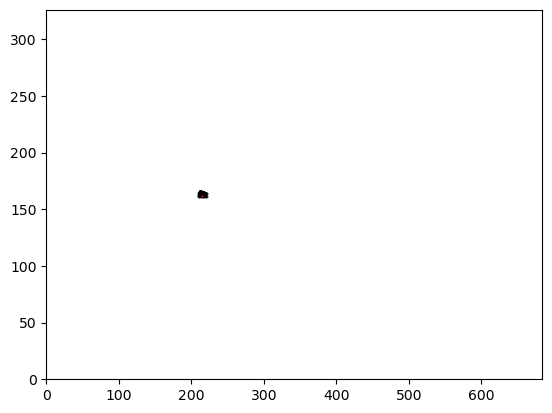

In [7]:
fig, ax = plt.subplots()
ax.set_xlim(0, len(im_binary[0]))
ax.set_ylim(0, len(im_binary))

ax.plot(x, y, color = 'k', marker='.', markersize=0.5)
ax.plot(track[0], track[1], color = 'r', marker='.', markersize=1)

In [16]:
# abro y analizo video
video = cv.VideoCapture('Camo Recording 2024-05-17 11-54-12 - 5Hz.mp4')
lim = [319, 1009, 182, 513]
_, im = video.read()
t,x,y = tracker(video, lim)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


c:\Users\pauli\miniconda3\envs\Labo6y7_env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pauli\miniconda3\envs\Labo6y7_env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


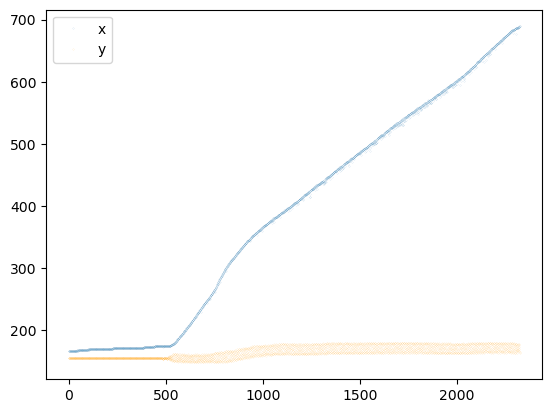

In [25]:
plt.plot(t[:2322],x,'.',markersize=0.1,label='x')
plt.plot(t[:2322],y,'.',color='orange',markersize=0.1,label='y')
plt.legend()

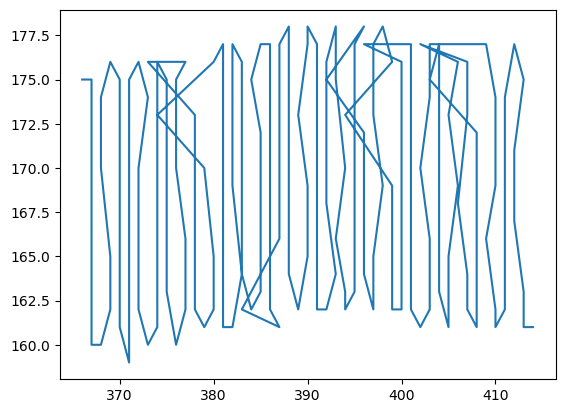

In [32]:
plt.plot(x[1000:1200],y[1000:1200],markersize=1)